# LEGO Bricks ML Vision - Inference Pipeline Demonstration
We will use the lego_cli.py file to demonstrate the inference pipeline. The pipeline will consist of the following steps:

1. **Setup and Environment Configuration**: Ensure the necessary environment is set up, including cloning the repository and verifying CUDA availability.
2. **Image Selection**: Randomly select an image from the available test images.
3. **Inference Execution**: Run the full inference pipeline on the selected image, including brick detection, stud detection, and dimension classification.
4. **Result Visualization**: Display the results, including annotated images and detected dimensions.



## 1. Setup and Environment Configuration



In [1]:
# Check for "LEGO_BRICKS_ML_VISION" folder in the cwd folder branch

import os
import sys
from pathlib import Path
import subprocess
import logging
import rich.logging as rlog

# Set up rich logger with emoji support

logger = logging.getLogger("inference_demo")
if not logger.handlers:
    handler = rlog.RichHandler(markup=True)
    logger.setLevel(logging.INFO)
    logger.addHandler(handler)
    logger.info("🚀 Inference Demo Logger initialized")


def check_repo_clone():
    """
    Check if the cwd name matches the repo name.
    If not, check if the parent folder matches the repo name.
    If not, clone the repo.

    Returns the local repo root path and adds it to the sys.path
    """
    # Set up rich logger
    logger = logging.getLogger("repo_setup")
    handler = rlog.RichHandler(rich_tracebacks=True, markup=True)
    logger.setLevel(logging.INFO)
    if not logger.handlers:
        logger.addHandler(handler)
    
    userGithub = "MiguelDiLalla"
    repoGithub = "LEGO_Bricks_ML_Vision"
    repo_url = f"https://github.com/{userGithub}/{repoGithub}.git"

    cwd = Path.cwd()
    cwd_name = cwd.name
    cwd_parent = cwd.parent

    logger.info(f"Checking for repository: [bold blue]{repoGithub}[/bold blue]")
    
    if cwd_name != repoGithub and cwd_parent.name != repoGithub:
        logger.info(f"Repository not found in current path or parent directory")
        logger.info(f"Cloning from [green]{repo_url}[/green]...")
        
        try:
            subprocess.run(["git", "clone", repo_url], check=True)
            logger.info(f"Repository successfully cloned")
            # Add the repo to the sys.path
            sys.path.append(cwd / repoGithub)
            # Change the cwd to the repo root
            os.chdir(cwd / repoGithub)
            return cwd / repoGithub
        except subprocess.CalledProcessError as e:
            logger.error(f"Failed to clone repository: {e}")
            logger.error(f"Please clone manually with: git clone {repo_url}")
            raise RuntimeError(f"Repository setup failed: {e}")
    else:
        repo_path = cwd if cwd_name == repoGithub else cwd_parent
        logger.info(f"Repository [bold blue]{repoGithub}[/bold blue] already available at [bold green]{repo_path}[/bold green]")
        
        # Add the repo to the sys.path
        sys.path.append(repo_path)
        # Change the cwd to the repo root (and log it)
        logger.info(f"Changing working directory to: [bold green]{repo_path}[/bold green]")
        os.chdir(repo_path)
        return repo_path

repo_clone_path = check_repo_clone()


[03/17/25 16:18:29] INFO     🚀 Inference Demo Logger initialized                                     ]8;id=928255;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\2617228.py\2617228.py]8;;\:]8;id=199227;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\2617228.py#17\17]8;;\

[03/17/25 16:18:29] INFO     Checking for repository: LEGO_Bricks_ML_Vision                           ]8;id=969533;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\2617228.py\2617228.py]8;;\:]8;id=26264;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\2617228.py#43\43]8;;\

                    INFO     Repository LEGO_Bricks_ML_Vision already available at                    ]8;id=364327;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\2617228.py\2617228.py]8;;\:]8;id=750245;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\2617228.py#63\63]8;;\
                             c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision                              

                    INFO     Changing working directory to:                                           ]8;id=946329;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\2617228.py\2617228.py]8;;\:]8;id=489141;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\2617228.py#68\68]8;;\
                             c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision                              

In [2]:

# Verify CUDA availability
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
logger.info(f"Using device: {device}")


[03/17/25 16:18:33] INFO     Using device: cpu                                                      ]8;id=173186;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4022083905.py\4022083905.py]8;;\:]8;id=987903;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4022083905.py#4\4]8;;\

In [3]:
print(
    subprocess.run(["python", "lego_cli.py", "--help"],
                    capture_output=True, text=True).stdout
                    )

In [4]:
print(
        subprocess.run(["python", "lego_cli.py", "cleanup", "--results-only"], 
                       capture_output=True,
                       input="Y",
                       text=True,  
                       check=True).stdout
    )


## 2. Run the inference pipeline:


### 2.1. Brick Detection

In [5]:
import random
from PIL import Image
import math
from IPython.display import display

def run_bricks_detectron(num_images=1, folder=Path.cwd() / "presentation" / "Test_images" / "BricksPics", output_directory=Path.cwd() / "results"):
    """
    Run the bricks detection cli comand on randomly chosen images from the folder.

    Args:
        num_images (int): Number of images to process
        folder (Path): Path to folder containing source images
        output_directory (Path): Path to store results

    Returns:
        None: Displays results using IPython display
    """
    # Get list of images and select random samples
    bricks_images = list(folder.glob("*.jpg"))
    logger.info(f"Found {len(bricks_images)} images in {folder}")
    selected_images = random.sample(bricks_images, min(num_images, len(bricks_images)))
    
    # Process each selected image
    results = []
    for img_path in selected_images:
        logger.info(f"Processing image: {img_path.name}")
        
        # Run brick detection using CLI
        subprocess.run([
                "python", "lego_cli.py", "detect-bricks",
                "--image", str(img_path),
                "--output", str(output_directory),
                "--conf", "0.25",
                "--save-annotated",
                "--no-save-json",
                "--clean-exif"
            ], capture_output=True, text=True, check=False)  # Changed check=True to False
            
        
        # Get the result image path and load it
        result_path = output_directory / img_path.stem / "brick_detection.jpg"
        if result_path.exists():
            results.append(Image.open(result_path))
            
    if not results:
        logger.warning("No results generated")
        return

    # Normalize and display results side by side
    target_height = min(img.height for img in results)
    normalized_images = []
    total_width = 0
    
    for img in results:
        aspect_ratio = img.width / img.height
        new_width = int(target_height * aspect_ratio)
        resized_img = img.resize((new_width, target_height), Image.Resampling.LANCZOS)
        normalized_images.append(resized_img)
        total_width += new_width
        
    # Create combined image
    combined_image = Image.new('RGB', (total_width, target_height))
    x_offset = 0
    for img in normalized_images:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width
    
    display(combined_image)

    return selected_images

# Run stud detection on 3 random images
scanned_bricks_images = run_bricks_detectron(num_images=3)

[03/17/25 16:18:55] INFO     Found 8 images in                                                       ]8;id=158751;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\37523296.py\37523296.py]8;;\:]8;id=21569;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\37523296.py#20\20]8;;\
                             c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\T               
                             est_images\BricksPics                                                                 

                    INFO     Processing image: image_696.jpg                                         ]8;id=539645;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\37523296.py\37523296.py]8;;\:]8;id=305596;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\37523296.py#26\26]8;;\

[03/17/25 16:19:09] INFO     Processing image: image_699.jpg                                         ]8;id=502668;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\37523296.py\37523296.py]8;;\:]8;id=678928;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\37523296.py#26\26]8;;\

[03/17/25 16:19:23] INFO     Processing image: image_668.jpg                                         ]8;id=455775;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\37523296.py\37523296.py]8;;\:]8;id=886420;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\37523296.py#26\26]8;;\

[03/17/25 16:19:35] WARNING  No results generated                                                    ]8;id=673688;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\37523296.py\37523296.py]8;;\:]8;id=171919;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\37523296.py#46\46]8;;\

### 2.2. Stud Detection:

In [6]:
def run_studs_detectron(num_images=1, folder=Path.cwd() / "presentation" / "Test_images" / "StudsPics", output_directory=Path.cwd() / "results"):
    """
    Run the studs detection CLI command on randomly chosen images from the folder.

    Args:
        num_images (int): Number of images to process
        folder (Path): Path to folder containing source images
        output_directory (Path): Path to store results

    Returns:
        None: Displays results using IPython display
    """
    # Get list of images and select random samples
    studs_images = list(folder.glob("*.jpg"))
    logger.info(f"Found {len(studs_images)} images in {folder}")
    selected_images = random.sample(studs_images, min(num_images, len(studs_images)))
    
    # Process each selected image
    results = []
    for img_path in selected_images:
        logger.info(f"Processing image: {img_path.name}")
        
        # Run stud detection using CLI
        subprocess.run([
            "python", "lego_cli.py", "detect-studs",
            "--image", str(img_path),
            "--output", str(output_directory),
            "--conf", "0.25",
            "--save-annotated",
            "--clean-exif"
        ], check=True)
        
        # Get the result image path and load it
        result_path = output_directory / img_path.stem / "stud_detection.jpg"
        if result_path.exists():
            results.append(Image.open(result_path))
    
    if not results:
        logger.warning("No results generated")
        return
        
    # Normalize and display results side by side
    target_height = min(img.height for img in results)
    normalized_images = []
    total_width = 0
    
    for img in results:
        aspect_ratio = img.width / img.height
        new_width = int(target_height * aspect_ratio)
        resized_img = img.resize((new_width, target_height), Image.Resampling.LANCZOS)
        normalized_images.append(resized_img)
        total_width += new_width
        
    # Create combined image
    combined_image = Image.new('RGB', (total_width, target_height))
    x_offset = 0
    for img in normalized_images:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width
    
    # re-scale the combined image respecting ratio to 300px height
    combined_image = combined_image.resize((int(combined_image.width * (300 / combined_image.height)), 300), Image.Resampling.LANCZOS)
    display(combined_image)

    return selected_images

# Run stud detection on 3 random images
scanned_studs_images = run_studs_detectron(num_images=3)

                    INFO     Found 20 images in                                                    ]8;id=72406;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4293593542.py\4293593542.py]8;;\:]8;id=867934;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4293593542.py#15\15]8;;\
                             c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation                 
                             \Test_images\StudsPics                                                                

                    INFO     Processing image: image_139_LegoBrick_0_c86.jpg                       ]8;id=834309;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4293593542.py\4293593542.py]8;;\:]8;id=818956;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4293593542.py#21\21]8;;\

[03/17/25 16:19:43] INFO     Processing image: image_224_LegoBrick_0_c83.jpg                       ]8;id=425910;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4293593542.py\4293593542.py]8;;\:]8;id=144036;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4293593542.py#21\21]8;;\

[03/17/25 16:19:52] INFO     Processing image: image_113_LegoBrick_2_c82.jpg                       ]8;id=211640;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4293593542.py\4293593542.py]8;;\:]8;id=343878;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4293593542.py#21\21]8;;\

[03/17/25 16:20:00] WARNING  No results generated                                                  ]8;id=186370;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4293593542.py\4293593542.py]8;;\:]8;id=992250;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\4293593542.py#39\39]8;;\

### 2.3 Full clasification DEMO

In [7]:
import random
from PIL import Image

def run_multiple_inferences(num_images=3, seed=None, folder = Path.cwd() /  "presentation" /  "Test_images" / "BricksPics", output_directory = Path.cwd() / "results"):
    """
    Run inference on multiple random images and display results side by side using PIL
    Images are normalized to the same height while preserving aspect ratios
    
    Args:
        num_images (int): Number of images to process (default=3)
        seed (int): Random seed for reproducibility (default=None)
    """
    if seed is not None:
        random.seed(seed)

    bricks_images = list(folder.glob("*.jpg"))
    #LOG NUMBER OF AVALIABLE IMAGES
    logger.info(f"Number of available images: {len(bricks_images)}")
    
    
    # Select random images
    selected_images = random.sample(bricks_images, min(num_images, len(bricks_images)))
    #log list of selected images
    logger.info(f"Selected images: {selected_images}")
    
    # Run inference on each image
    results = []
    for img_path in selected_images:
        logger.info(f"Processing image: {img_path.name}")
        
        subprocess.run(["python", "lego_cli.py", "infer", "--force-run",
                       "--image", str(img_path), 
                       "--output", str(output_directory)], 
                       check=True)
        
        result_path = output_directory / img_path.stem / 'full_analysis.jpg'
        results.append(Image.open(result_path))
    
    # Normalize height while preserving aspect ratio
    target_height = min(img.height for img in results)
    normalized_images = []
    total_width = 0
    
    for img in results:
        # Calculate new width to maintain aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(target_height * aspect_ratio)
        resized_img = img.resize((new_width, target_height), Image.Resampling.LANCZOS)
        normalized_images.append(resized_img)
        total_width += new_width
    
    # Create and populate the combined image
    combined_image = Image.new('RGB', (total_width, target_height))
    x_offset = 0
    for img in normalized_images:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width
    
    display(combined_image)

run_multiple_inferences(num_images=3)


                    INFO     Number of available images: 8                                         ]8;id=199426;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\1725236674.py\1725236674.py]8;;\:]8;id=236446;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\1725236674.py#18\18]8;;\

                    INFO     Selected images:                                                      ]8;id=486241;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\1725236674.py\1725236674.py]8;;\:]8;id=606544;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\1725236674.py#24\24]8;;\
                             [WindowsPath('c:/Users/User/Projects_Unprotected/LEGO_Bricks_ML_Visio                 
                             n/presentation/Test_images/BricksPics/image_277.jpg'),                                
                             WindowsPath('c:/Users/User/Projects_Unprotected/LEGO_Bricks_ML_Vision                 
                             /presentation/Test_images/BricksPics/image_696.jpg'),                                 
                             WindowsPath('c:/Users/User/Projects_Unprotected/LEGO_Bricks_ML_Vision                 
                             /presentation/Test_images/BricksPics/image_14.jpg')]                                  

                    INFO     Processing image: image_277.jpg                                       ]8;id=863991;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\1725236674.py\1725236674.py]8;;\:]8;id=873640;file://C:\Users\User\AppData\Local\Temp\ipykernel_8844\1725236674.py#29\29]8;;\

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\results\\image_277\\full_analysis.jpg'

## 3. Micelanous

### 3.1 Detection metadata fingerprint:

In order to avoid reprocessing images that have already been scanned by the current project algorithms, metadata storing has been implemented in the detection pipeline. 

Information about the last "scan" that the file underwent is stored inside the EXIF UserComment tag along repository coordinates and execution enviroment information.

The following code snippet shows how to extract the metadata from an image file:

(note that the metadata corresponding to a studs detection got the extra field "dimension")


In [ ]:
image_path = random.choice(scanned_bricks_images)
print(
    subprocess.run(["python", "lego_cli.py", "metadata", "inspect", str(image_path)],
                         capture_output=True, text=True)
                         .stdout)

image_path = random.choice(scanned_studs_images)
print(
    subprocess.run(["python", "lego_cli.py", "metadata", "inspect", str(image_path)],
                         capture_output=True, text=True)
                         .stdout)

┌───────────────────────────────────────┐
│ Metadata Inspection for image_699.jpg │
└───────────────────────────────────────┘
┌──────────────────────┬──────────────────────────────────────────────────────┐
│ boxes_coordinates    │ <nested>                                             │
│   0                  │ <nested>                                             │
│     coordinates      │ [683.3895874023438, 185.9927978515625, 800.0,        │
│                      │ 265.7216491699219]                                   │
│     confidence       │ 0.5837348103523254                                   │
│     class            │ 0                                                    │
│   1                  │ <nested>                                             │
│     coordinates      │ [400.0860900878906, 370.731201171875,                │
│                      │ 594.337158203125, 435.2976989746094]                 │
│     confidence       │ 0.5804970264434814                               

And if one wants to cleanup the fingerprint present inside the images from a given folder:

In [ ]:
images_folder_path = scanned_bricks_images[0].parent
print(
    subprocess.run(["python", "lego_cli.py", "metadata", "clean-batch", str(images_folder_path), '--force'],
                   capture_output=True, text=True, check=True).stdout)

images_folder_path = scanned_studs_images[0].parent
print(
    subprocess.run(["python", "lego_cli.py", "metadata", "clean-batch", str(images_folder_path), '--force'],
                   capture_output=True, text=True, check=True).stdout)

┌─────────────────────────┐
│ Batch Metadata Cleaning │
└─────────────────────────┘
            Summary             
┌──────────────────────┬───────┐
│ Metric               │ Count │
├──────────────────────┼───────┤
│ Total images         │ 8     │
│ Images with metadata │ 8     │
└──────────────────────┴───────┘

⠋ Cleaning metadata... ---------------------------------------- 0:00:00
⠙ Cleaning metadata... ----------------------------------- ---- 0:00:00
  Cleaning metadata... ---------------------------------------- 0:00:00
Metadata cleaning completed!

┌─────────────────────────┐
│ Batch Metadata Cleaning │
└─────────────────────────┘
            Summary             
┌──────────────────────┬───────┐
│ Metric               │ Count │
├──────────────────────┼───────┤
│ Total images         │ 20    │
│ Images with metadata │ 2     │
└──────────────────────┴───────┘

⠋ Cleaning metadata... ---------------------------------------- 0:00:00
  Cleaning metadata... ---------------------------

### 3.2. Labeling tools

To create the primal dataset for this project the LabelMe tool was selected due to its portability and ease of use. This tool output is not directly compatible with Ultralitycs YOLO format, so conversion code was implemenmted to create compatible .txt files out of the .json files generated by LabelMe.



In [ ]:
LabelMe_labels_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\Test_Labels\LabelMe_jsons"
Converted_YOLO_labels_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\results\YOLO_Labels"

print(
    subprocess.run(["python", "lego_cli.py", "data-processing", "labelme-to-yolo", "--input", LabelMe_labels_folder, "--output", Converted_YOLO_labels_folder, "--clean"],
                   capture_output=True, text=True, check=True).stdout)

┌───────────────────────────────────┐
│ Converting LabelMe to YOLO Format │
└───────────────────────────────────┘

Converting annotations... ----------------------------------------   0% -:--:--
Converting annotations... ----------------------------------------   0% -:--:--
Converting annotations... ----------------------------------------   0% -:--:--
Converting annotations... ---------------------------------------- 100% 0:00:00
                              Conversion Summary                               
┌────────────────────────┬────────────────────────────────────────────────────┐
│ Metric                 │ Value                                              │
├────────────────────────┼────────────────────────────────────────────────────┤
│ Files Processed        │ 17                                                 │
│ Successful Conversions │ 17                                                 │
│ Failed Conversions     │ 0                                                  │
│ Suc

For the second dataset that was created (for LegoBricksStuds detectron model) it was way easier to annotate the center of each connection pin (there can be many per image) and transform that point into a boinding box algorithmically.

The algorithm assumes that the sum of all bboxes areas should amunt to 40% of the total, then being aware of the number of keypoint and 9image dimensions it calculates square bboxes (or rectangle if they are near the image borders) that are outputed as LabelMe .json bbox annotations that can be converted to YOLO format by the previously described method.

In [ ]:
LabelMe_keypoints_labels_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\Test_Labels\LabelMe_keypoints"
Converted_bboxes_labels_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\results\LabelMe_bboxes"

print(
    subprocess.run([
        "python", "lego_cli.py", "data-processing", "keypoints-to-bboxes",
        "--input", LabelMe_keypoints_labels_folder,
        "--output", Converted_bboxes_labels_folder
    ], capture_output=True, text=True, check=True).stdout
)

┌────────────────────────────────────────┐
│ Converting Keypoints to Bounding Boxes │
└────────────────────────────────────────┘

Converting keypoints... ----------------------------------------   0% -:--:--
Converting keypoints... ----------------------------------------   0% -:--:--
Converting keypoints... ---------------------------------------- 100% 0:00:00
                              Conversion Summary                               
┌────────────────────────┬────────────────────────────────────────────────────┐
│ Metric                 │ Value                                              │
├────────────────────────┼────────────────────────────────────────────────────┤
│ Files Processed        │ 9                                                  │
│ Successful Conversions │ 9                                                  │
│ Failed Conversions     │ 0                                                  │
│ Success Rate           │ 100.0%                                           

Here a visualization of the conversion:

┌────────────────────────────┐
│ Annotation Conversion Demo │
└────────────────────────────┘

Processing samples... ----------------------------------------   0% -:--:--✓ Processed image_1729.json
✓ Processed image_1543.json

Processing samples... -------------------------- -------------  67% 0:00:01✓ Processed image_196.json

Processing samples... ---------------------------------------- 100% 0:00:00

Demo results saved to: 
C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\results\DEMO_Labels_Co
nversion\demo_20250313_165937



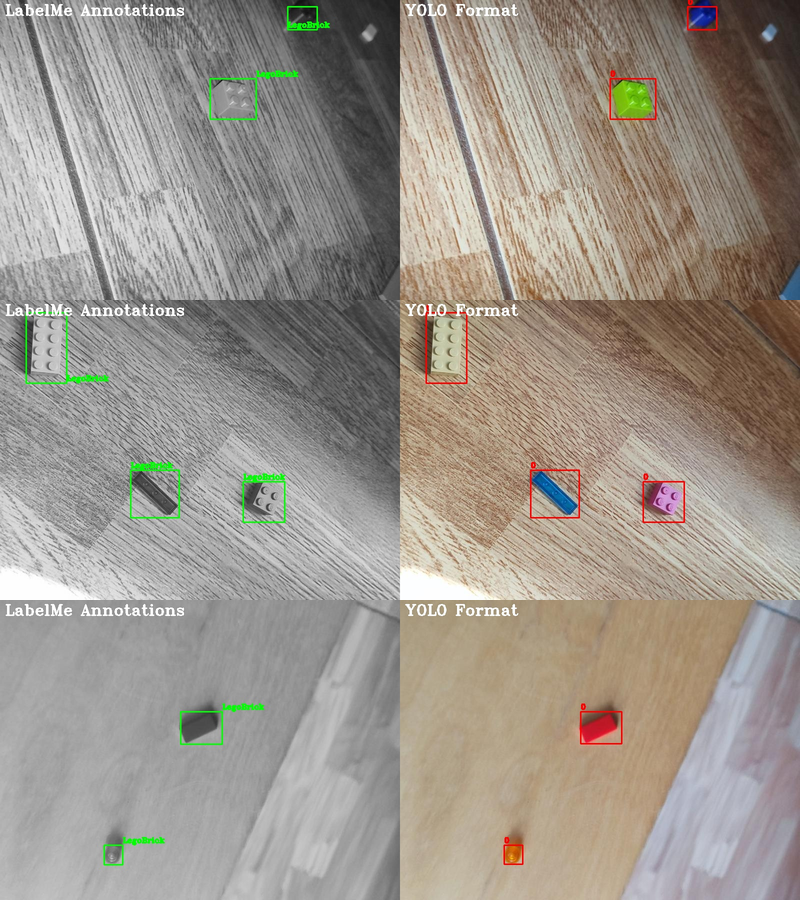

In [ ]:
from pathlib import Path
from PIL import Image
from IPython.display import display

input_folder = LabelMe_labels_folder #LabelMe_keypoints_labels_folder
output_DEMO_labels_Conversion_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\results\DEMO_Labels_Conversion"
number_of_samples = 3  # You can adjust the number of samples as needed

print(
    subprocess.run([
        "python", "lego_cli.py", "data-processing", "demo-conversion",
        "--input", input_folder,
        "--samples", str(number_of_samples),
        "--output", output_DEMO_labels_Conversion_folder
    ], capture_output=True, text=True, check=True).stdout
)

def showcase_last_labels_conversion(folder = output_DEMO_labels_Conversion_folder):
    '''
    Fetch the last created folder inside the inputed folder and display 
    the available .jpg images stacked vertically while preserving aspect ratio
    '''
    
    # Get the latest created folder
    folders = list(Path(folder).glob('*'))
    if not folders:
        logger.warning("No conversion folders found")
        return
        
    latest_folder = max(folders, key=lambda x: x.stat().st_mtime)
    
    # Get all jpg images
    images = list(latest_folder.glob('*.jpg'))
    if not images:
        logger.warning("No images found in the latest conversion folder")
        return
        
    # Load images
    pil_images = [Image.open(img) for img in images]
    
    # Calculate target width while maintaining aspect ratio
    target_width = 800  # Set a fixed target width
    scaled_images = []
    total_height = 0
    
    for img in pil_images:
        # Calculate new height maintaining aspect ratio
        ratio = target_width / img.width
        new_height = int(img.height * ratio)
        scaled_img = img.resize((target_width, new_height), Image.Resampling.LANCZOS)
        scaled_images.append(scaled_img)
        total_height += new_height
    
    # Create combined image
    combined_image = Image.new('RGB', (target_width, total_height))
    y_offset = 0
    
    # Paste images
    for img in scaled_images:
        combined_image.paste(img, (0, y_offset))
        y_offset += img.height
    
    display(combined_image)

showcase_last_labels_conversion()

┌────────────────────────────┐
│ Annotation Conversion Demo │
└────────────────────────────┘

Processing samples... ----------------------------------------   0% -:--:--✓ Processed image_87_LegoBrick_4_c72.json
✓ Processed image_643_LegoBrick_2_c84.json
✓ Processed image_10_LegoBrick_0_c87.json
✓ Processed image_641_LegoBrick_1_c84.json
✓ Processed image_641_LegoBrick_0_c85.json

Processing samples... ---------------------------------------- 100% 0:00:00

Demo results saved to: 
C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\results\DEMO_Labels_Co
nversion\demo_20250313_165946



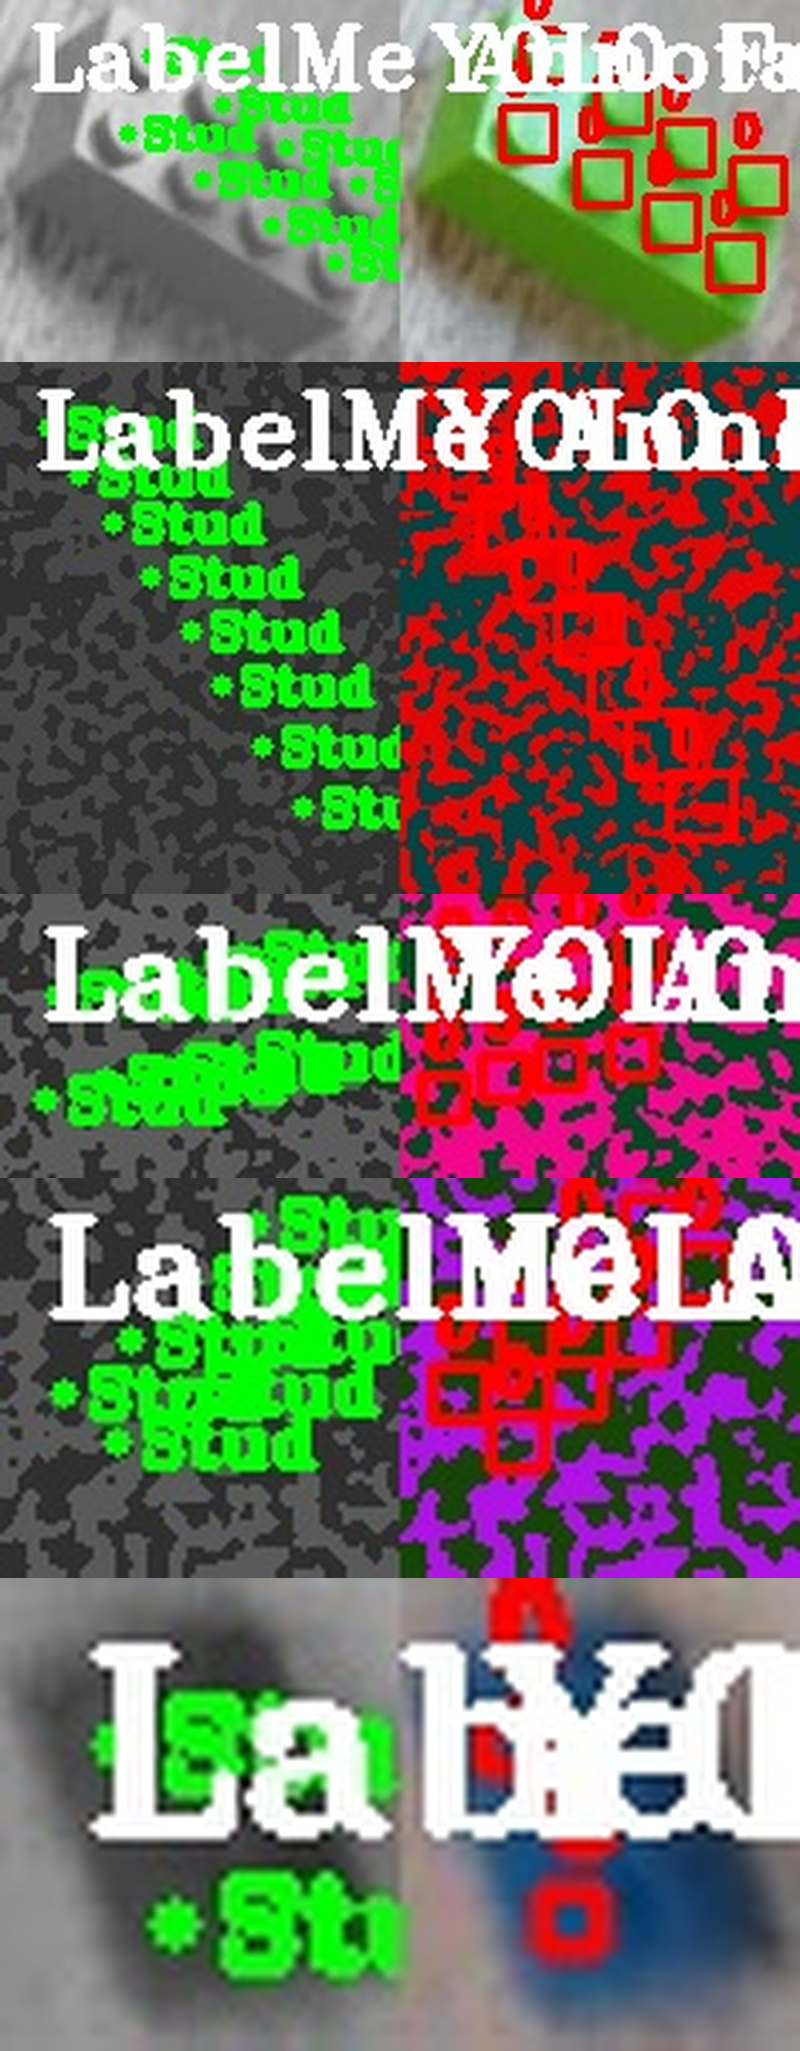

In [ ]:
input_folder = LabelMe_keypoints_labels_folder
output_DEMO_labels_Conversion_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\results\DEMO_Labels_Conversion"
number_of_samples = 5  # You can adjust the number of samples as needed

print(
    subprocess.run([
        "python", "lego_cli.py", "data-processing", "demo-conversion",
        "--input", input_folder,
        "--samples", str(number_of_samples),
        "--output", output_DEMO_labels_Conversion_folder
    ], capture_output=True, text=True, check=True).stdout
)

showcase_last_labels_conversion()

### 3.3. Multiclass Labeling:

Circleling back to the original goal of the project, images containing lego bricks can now be automatically labeled by dimension in order to attempt training a multiclass detectron model.

Reading... ---------------------------------------- 0.0/76.3 kB -:--:--
Reading... ---------------------------------------- 0.0/76.3 kB -:--:--
Reading... ---------------------------------------- 0.0/72.8 kB -:--:--
Reading... ---------------------------------------- 0.0/72.8 kB -:--:--
Reading... ---------------------------------------- 0.0/60.8 kB -:--:--
Reading... ---------------------------------------- 0.0/60.8 kB -:--:--
Reading... ---------------------------------------- 0.0/41.3 kB -:--:--
Reading... ---------------------------------------- 0.0/41.3 kB -:--:--
Reading... ---------------------------------------- 0.0/42.7 kB -:--:--
Reading... ---------------------------------------- 0.0/42.7 kB -:--:--
Reading... ---------------------------------------- 0.0/34.3 kB -:--:--
Reading... ---------------------------------------- 0.0/34.3 kB -:--:--
Reading... ---------------------------------------- 0.0/117.1 kB -:--:--
Reading... ---------------------------------------- 0.0/117.1 k

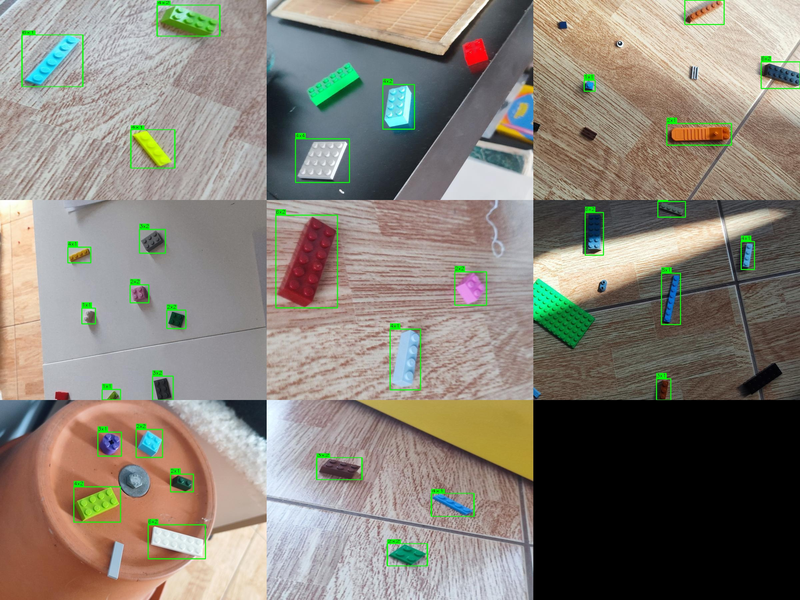

In [ ]:
from datetime import *

def run_and_visualize_batch_inference():
    """
    Run batch inference on test bricks folder and visualize results.
    
    1. Creates timestamped output folder
    2. Processes all images using brick detection model
    3. Draws detections with class names
    4. Displays results in a grid
    """
    # Setup paths
    input_folder = Path.cwd() / "presentation" / "Test_images" / "BricksPics"
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Convert working directory to Path object
    working_dir = Path.cwd()
    output_folder = working_dir / "results" / f"batch_inference_{timestamp}"
    os.makedirs(output_folder, exist_ok=True)

    # execute batch inference
    print(
        subprocess.run([
            "python", "lego_cli.py", "batch-inference",
            "--input", input_folder,
            "--output", output_folder
        ], capture_output=True, text=True, check=True).stdout
    )

    # store the .json file path (last created) from the output folder
    json_files = list(output_folder.glob("*.json"))
    last_json_file = max(json_files, key=os.path.getctime) if json_files else None
    if last_json_file:
        print(f"Last created JSON file: {last_json_file}")
    else:
        print("No JSON files found")
        return

    # create the annotated samples
    annotated_samples_folder = output_folder / "annotated_samples"
    os.makedirs(annotated_samples_folder, exist_ok=True)

    print(
        subprocess.run([
            "python", "lego_cli.py", "visualize-batch",
            Path(last_json_file), # "--output", annotated_samples_folder,
            "--samples", "17",
        ], capture_output=True, text=True, check=True).stdout
    )
    
    # Display the annotated samples stacked vertically
    annotated_batches = list(output_folder.glob("*.jpg"))
    if not annotated_batches:
        print("No annotated samples found")
        return
    
    # Load images
    pil_images = [Image.open(img) for img in annotated_batches]
    # Calculate target width while maintaining aspect ratio
    target_width = 800  # Set a fixed target width
    scaled_images = []
    total_height = 0

    for img in pil_images:
        # Calculate new height maintaining aspect ratio
        ratio = target_width / img.width
        new_height = int(img.height * ratio)
        scaled_img = img.resize((target_width, new_height), Image.Resampling.LANCZOS)
        scaled_images.append(scaled_img)
        total_height += new_height

    # Create combined image
    combined_image = Image.new('RGB', (target_width, total_height))
    y_offset = 0

    for img in scaled_images:
        combined_image.paste(img, (0, y_offset))
        y_offset += img.height


    combined_image_path = output_folder / "combined_image.jpg"
    combined_image.save(combined_image_path)
    display(combined_image)

run_and_visualize_batch_inference()